<a href="https://colab.research.google.com/github/GabrielMCC2020/ModelosIA/blob/main/oficial_model_rmsprop_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip data.zip -d ./data

Archive:  data.zip
   creating: ./data/data/rojo/
  inflating: ./data/data/rojo/rojo (1).jpg  
  inflating: ./data/data/rojo/rojo (10).jpg  
  inflating: ./data/data/rojo/rojo (100).jpg  
  inflating: ./data/data/rojo/rojo (101).jpg  
  inflating: ./data/data/rojo/rojo (102).jpg  
  inflating: ./data/data/rojo/rojo (103).jpg  
  inflating: ./data/data/rojo/rojo (104).jpg  
  inflating: ./data/data/rojo/rojo (105).jpg  
  inflating: ./data/data/rojo/rojo (106).jpg  
  inflating: ./data/data/rojo/rojo (107).jpg  
  inflating: ./data/data/rojo/rojo (108).jpg  
  inflating: ./data/data/rojo/rojo (109).jpg  
  inflating: ./data/data/rojo/rojo (11).jpg  
  inflating: ./data/data/rojo/rojo (110).jpg  
  inflating: ./data/data/rojo/rojo (111).jpg  
  inflating: ./data/data/rojo/rojo (112).jpg  
  inflating: ./data/data/rojo/rojo (113).jpg  
  inflating: ./data/data/rojo/rojo (114).jpg  
  inflating: ./data/data/rojo/rojo (115).jpg  
  inflating: ./data/data/rojo/rojo (116).jpg  
  inflating: .

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import copy

In [3]:
train_dataset = torchvision.datasets.ImageFolder('../../content/data/data/train',
                                                  transforms.Compose([
                                                  transforms.RandomResizedCrop(224),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.RandomRotation(20),
                                                  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                                ]))
val_dataset = torchvision.datasets.ImageFolder('../../content/data/data/val',
                                                  transform=transforms.Compose([
                                                  transforms.Resize(256),
                                                  transforms.CenterCrop(224),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                                ]))
test_dataset = torchvision.datasets.ImageFolder('../../content/data/data/test',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])
                                                ]))

In [4]:
# Arquitectura de la red
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 256, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3)
        self.fc1 = nn.Linear(512*26*26, 50)
        self.fc2 = nn.Linear(50, 2)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.bn1(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
network = Network()

In [5]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 1140
    Root location: ../../content/data/data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 180
    Root location: ../../content/data/data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.2

In [6]:
batch_size_train = 8
batch_size_test = 8
batch_size_val = 8
learning_rate = 0.001
num_epocas = 2
step_log = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size = batch_size_train,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size = batch_size_test,
                                         shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size = batch_size_val,
                                         shuffle=True)
class_names = train_dataset.classes

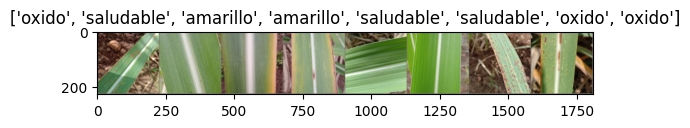

In [7]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [8]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(10, 256, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(256)
    self.conv3 = nn.Conv2d(256, 512, kernel_size=3)
    self.fc1 = nn.Linear(512*26*26,80)
    self.fc2 = nn.Linear(80,3)
  def forward(self, x):
    x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
    x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)
  def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
network = Network()

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_train = 0.0

    train_loss_values = []
    val_loss_values = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 25)
        scheduler.step()
        model.train()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss_train = running_loss / len(train_dataset)
        epoch_acc_train = running_corrects.double() / len(train_dataset)
        train_loss_values.append(epoch_loss_train)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))
        if epoch_acc_train > best_acc_train:
            best_acc_train = epoch_acc_train
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in val_loader:
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        epoch_loss_val = running_loss / len(val_dataset)
        epoch_acc_val = running_corrects.double() / len(val_dataset)
        val_loss_values.append(epoch_loss_val)
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, 'resnetxt.pth')
    time_elapsed = time.time() - since
    print("####################################################")
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best train accuracy: {:.4f}'.format(best_acc_train))
    print('Best val accuracy: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    # Save the loss values to history
    history = {'train_loss': train_loss_values, 'val_loss': val_loss_values}

    return model, history

In [10]:
def test_model(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for inputs, labels in test_loader:
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss /len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return test_model

In [11]:
def visualize_model(model, num_images):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode = was_training)

In [ ]:
optimizer = torch.optim.RMSprop(network.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_propio, history = train_model(network, criterion, optimizer, scheduler, num_epochs=24)

Epoch 0/23
-------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Loss: 375.5132 Acc: 0.3447
Val Loss: 1.0964 Acc: 0.2833
Epoch 1/23
-------------------------
Train Loss: 1.8296 Acc: 0.3307
Val Loss: 1.0883 Acc: 0.3444
Epoch 2/23
-------------------------
Train Loss: 1.1051 Acc: 0.3219
Val Loss: 1.0970 Acc: 0.3500
Epoch 3/23
-------------------------
Train Loss: 1.1110 Acc: 0.3465
Val Loss: 1.1321 Acc: 0.3778
Epoch 4/23
-------------------------
Train Loss: 1.0984 Acc: 0.3596
Val Loss: 1.0722 Acc: 0.3333
Epoch 5/23
-------------------------
Train Loss: 1.1494 Acc: 0.3412
Val Loss: 1.0993 Acc: 0.3389
Epoch 6/23
-------------------------
Train Loss: 1.0977 Acc: 0.3360
Val Loss: 1.0980 Acc: 0.3389
Epoch 7/23
-------------------------
Train Loss: 1.0959 Acc: 0.3386
Val Loss: 1.0963 Acc: 0.3389
Epoch 8/23
-------------------------
Train Loss: 1.0983 Acc: 0.3360
Val Loss: 1.0961 Acc: 0.3389
Epoch 9/23
-------------------------
Train Loss: 1.0951 Acc: 0.3421
Val Loss: 1.0966 Acc: 0.3389
Epoch 10/23
-------------------------
Train Loss: 1.0956 Acc: 0.3

In [ ]:
model_propio_test = test_model(model_propio)

Test Loss: 0.8211 Acc: 0.7111


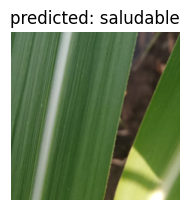

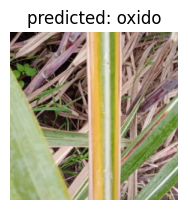

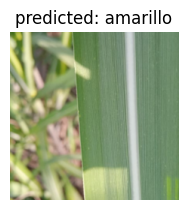

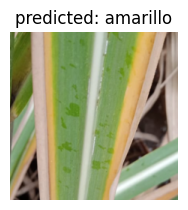

In [ ]:
visualize_model(model=model_propio, num_images = 4)

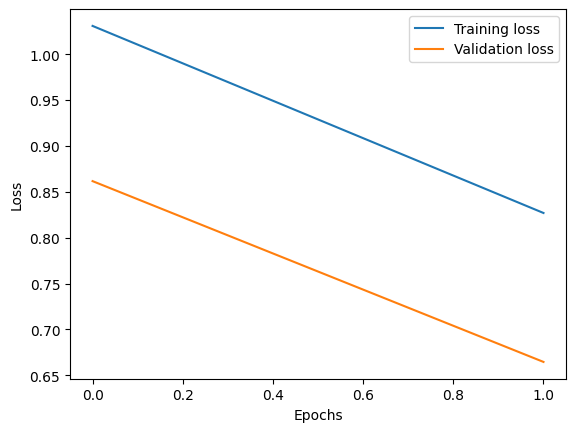

In [ ]:

# Entrenar el modelo y capturar el historial de pérdidas


# Graficar las pérdidas de entrenamiento y validación
epochs = range(len(history['train_loss']))
training_loss = history['train_loss']
validation_loss = history['val_loss']

plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()